## Nested Logit and Non-Proportional Patterns of Substitution

In [1]:
import sys

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append("../../../..")

from pymc_marketing.customer_choice.nested_logit import NestedLogit

We've seen how the Multinomial Logit model suffers from the IIA limitation that leads to implausible counterfactual inferences regarding market behaviour. We will show how the nested logit model specification avoids this property by adding more explicit structure to the choice scenarios that are modelled. 

In this notebook we will re-use the same heating choice data set seen in the Multinomial Logit example and apply a few different specifications of a nested logit model. 

In [2]:
df = pd.read_csv("../../../../data/choice_wide_heating.csv")
df

,idcase,depvar,ic_gc,ic_gr,ic_ec,ic_er,ic_hp,oc_gc,oc_gr,oc_ec,oc_er,oc_hp,income,agehed,rooms,region
0,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,553.34,505.60,237.88,7,25,6,ncostl
1,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,520.24,486.49,199.19,5,60,5,scostl
2,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,439.06,404.74,171.47,4,65,2,ncostl
3,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,483.00,425.22,222.95,2,50,4,scostl
4,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,404.41,389.52,178.49,2,25,6,valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,gc,766.39,877.71,751.59,869.78,942.70,142.61,136.21,474.48,420.65,203.00,6,20,4,mountn
896,897,gc,1128.50,1167.80,1047.60,1292.60,1297.10,207.40,213.77,705.36,551.61,243.76,7,45,7,scostl
897,898,gc,787.10,1055.20,842.79,1041.30,1064.80,175.05,141.63,478.86,448.61,254.51,5,60,7,scostl
898,899,gc,860.56,1081.30,799.76,1123.20,1218.20,211.04,151.31,495.20,401.56,246.48,5,50,6,scostl


## Single Layer Nesting

The important addition gained through the nested logit specification is the ability to specify "nests" of products in this way we can partition the market into "natural" groups of competing products ensuring that there is an inherent bias in the model towards a selective pattern of preference. As before we specify the models using formulas, but now we also add a nesting structure. 


In [22]:
## No Fixed Covariates
utility_formulas = [
    "gc ~ ic_gc + oc_gc | ",
    "ec ~ ic_ec + oc_ec | ",
    "gr ~ ic_gr + oc_gr | ",
    "er ~ ic_er + oc_er | ",
    "hp ~ ic_hp + oc_hp | ",
]


nesting_structure = {"central": ["gc", "ec"], "room": ["hp", "gr", "er"]}


nstL_1 = NestedLogit(
    df,
    utility_formulas,
    "depvar",
    covariates=["ic", "oc"],
    nesting_structure=nesting_structure,
)
nstL_1

We will dwell a bit on the manner in which these nests are specified and why. The nested logit model partitions the choice set into nests of alternatives that share common unobserved attributes (i.e., are more similar to each other). It computes the overall probability of choosing an alternative as the product of (1) The probability of choosing a nest (marginal probability), and (2) the probability of choosing an alternative within that nest (conditional probability, given that nest). In our case we want to isolate the probability of choosing a central heatings system and a room based heating system. 




Each of the alternatives `alt` is indexed to a nest. So that we can determine (§) the marginal probability of choosing `room` or `central` and (2) conditional probability of choosing `ec` given that you have chosen `central`. Our utilities are decomposed into contributions from fixed_covariates and alternative specific covariates: 

$$ U = Y + W + \epsilon $$ 

and the probabilities are derived from these decomposed utilitiies in the following manner. 

$$ P(i) = P(\text{choose nest B}) \cdot P(\text{choose i} | \text{ i} \in \text{B}) $$

where 

$$ P(\text{choose nest B}) = \dfrac{e^{W + \lambda_{k}I_{k}}}{\sum_{l=1}^{K} e^{W + \lambda_{l}I_{l}}} $$

and 

$$ P(\text{choose i} | \text{ i} \in \text{B}) = \dfrac{e^{Y_{i} / \lambda_{k}}}{\sum_{j \in B_{k}} e^{Y_{j} / \lambda_{k}}} $$

while the inclusive term $I_{k}$ is:

$$ I_{k} = ln \sum_{j \in B_{k}}  e^{Y_{j} / \lambda_{k}} \text{ and } \lambda_{k} \sim Beta(1, 1) $$

such that $I_{k}$ is used to "aggregate" utilities within a nest a "bubble up" their contribution to decision through the product of the marginal and conditional probabilities. More extensive details of this mathematical formulation can be found in Kenneth Train's "Discrete Choice Methods with Simulation". 


In [19]:
nstL_1.sample(
    fit_kwargs={
        "target_accept": 0.97,
        "nuts_sampler": "numpyro",
        "idata_kwargs": {"log_likelihood": True},
    }
)

Sampling: [alphas, betas, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

The model structure is quite a bit more complicated now than the simpler multinomial logit as we need to calculate the marginal and conditional probabilities within each of the nests seperately and then "bubble up" the probabilies as a product over the branching nests. These probabilities are deterministic functions of the summed utilities and are then fed into our categorical likelihood to calibrate our parameters against the observed data.  

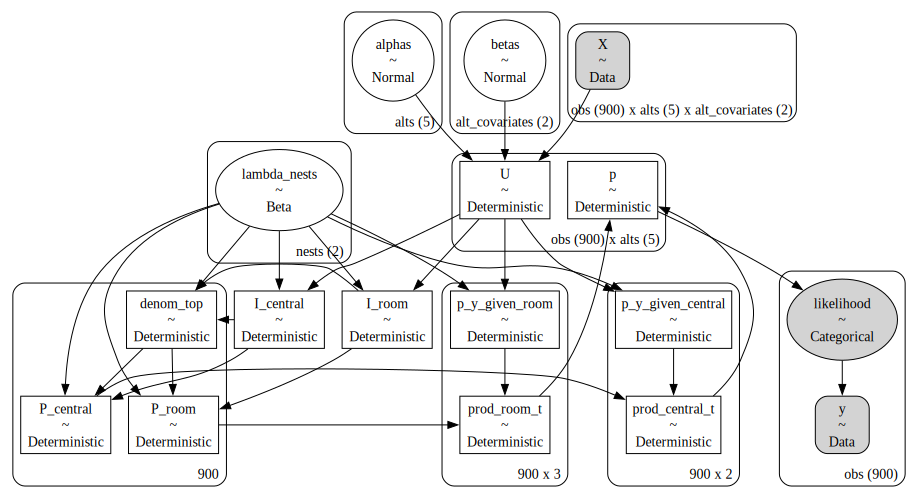

In [20]:
nstL_1.graphviz()

But again we are able to derive parameter estimates for the drivers of consumer choice and consult the model implications is in a standard Bayesian model. 

In [21]:
az.summary(nstL_1.idata, var_names=["betas", "alphas", "lambda_nests"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.001,0.001,-0.002,-0.000,0.000,0.000,2551.0,2882.0,1.0
betas[oc],-0.005,0.001,-0.008,-0.003,0.000,0.000,1294.0,1964.0,1.0
alphas[gc],0.006,0.708,-1.266,1.382,0.016,0.012,1972.0,2178.0,1.0
alphas[ec],-0.004,0.716,-1.341,1.320,0.017,0.012,1848.0,2208.0,1.0
alphas[gr],0.076,0.138,-0.178,0.346,0.003,0.003,2186.0,1921.0,1.0
alphas[er],1.316,0.335,0.694,1.932,0.009,0.005,1260.0,1885.0,1.0
alphas[hp],-0.003,0.988,-1.861,1.843,0.020,0.016,2548.0,2416.0,1.0
lambda_nests[central],0.757,0.126,0.526,0.972,0.004,0.002,985.0,1350.0,1.0
lambda_nests[room],0.602,0.119,0.386,0.809,0.004,0.002,995.0,1305.0,1.0


Here we see additionally lambda parameters for each of the nests. These terms measure how strongly correlated the unobserved utility components are for alternatives within the same nest. Closer to 0 indicates a high correlation, substitution happens mostly within the nest. Whereas a value closer to 1 implies lower within nest correlation suggesting IIA approximately holds within the nest. The options available for structuring a market can be quite extensive. As we might have "nests within nests" where the conditional probabilities flow through successive choices within segments of the market.

## Two Layer Nesting

In this PyMC marketing implementation we allow for the specification of a two-layer nesting representing succesive choices over a root nest and then nests within the child nests. 


In [7]:
## No fixed covariates
utility_formulas = [
    "gc ~ ic_gc + oc_gc | ",
    "ec ~ ic_ec + oc_ec | ",
    "gr ~ ic_gr + oc_gr | ",
    "er ~ ic_er + oc_er | ",
    "hp ~ ic_hp + oc_hp | ",
]


nesting_structure = {"central": ["gc", "ec"], "room": {"hp": ["hp"], "r": ["gr", "er"]}}

nstL_2 = NestedLogit(
    df,
    utility_formulas,
    "depvar",
    covariates=["ic", "oc"],
    nesting_structure=nesting_structure,
)
nstL_2

In [8]:
nstL_2.sample(
    fit_kwargs={
        "target_accept": 0.97,
        "nuts_sampler": "numpyro",
        "idata_kwargs": {"log_likelihood": True},
    }
)

Sampling: [alphas, betas, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

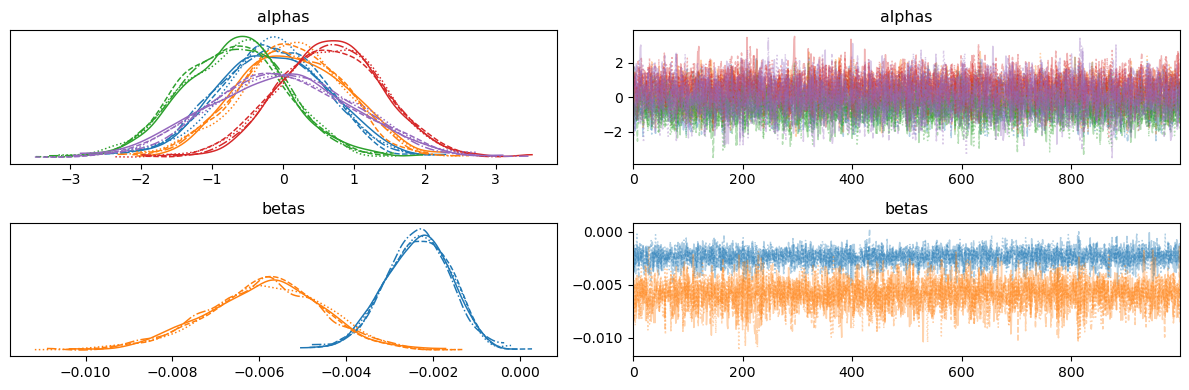

In [9]:
az.plot_trace(nstL_2.idata, var_names=["alphas", "betas"])
plt.tight_layout()

In [10]:
az.summary(nstL_2.idata, var_names=["betas", "alphas"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.002,0.001,-0.004,-0.001,0.000,0.000,4191.0,3349.0,1.0
betas[oc],-0.006,0.001,-0.008,-0.003,0.000,0.000,3509.0,2383.0,1.0
alphas[gc],-0.151,0.760,-1.576,1.248,0.015,0.012,2500.0,2546.0,1.0
alphas[ec],0.118,0.757,-1.229,1.594,0.015,0.011,2525.0,2419.0,1.0
alphas[gr],-0.690,0.740,-2.023,0.718,0.014,0.012,2623.0,2624.0,1.0
alphas[er],0.659,0.743,-0.701,2.051,0.015,0.013,2553.0,2205.0,1.0
alphas[hp],-0.014,1.002,-1.875,1.800,0.016,0.017,3720.0,2817.0,1.0


Again the parameter estimates seem to be recovered sensibly, but the question remains as to whether this additional nesting structure will help support plausible counterfactual reasoning. 

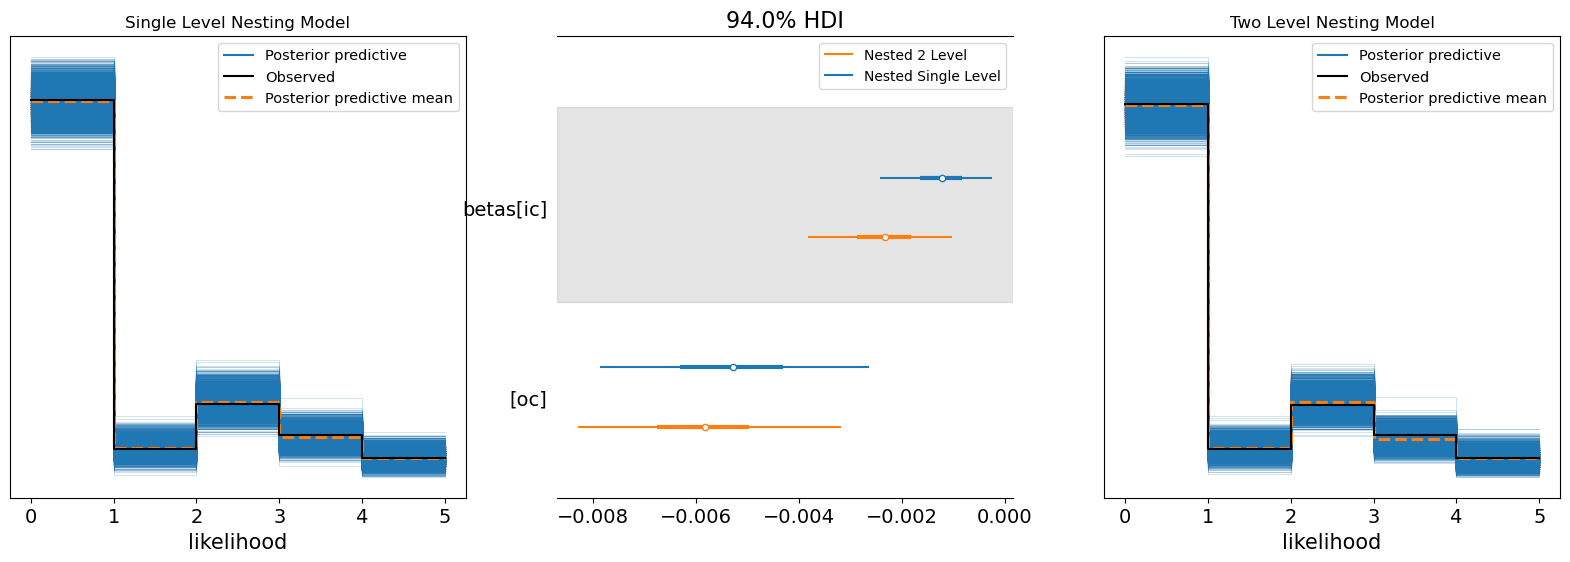

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs = axs.flatten()
az.plot_ppc(nstL_1.idata, ax=axs[0])
axs[0].set_title("Single Level Nesting Model")
az.plot_forest(
    [nstL_1.idata, nstL_2.idata],
    var_names=["betas"],
    combined=True,
    ax=axs[1],
    model_names=["Nested Single Level", "Nested 2 Level"],
)
axs[2].set_title("Two Level Nesting Model")
az.plot_ppc(nstL_2.idata, ax=axs[2]);

Both models seem to recover posterior predictive distributions well, but vary slightly in the estimate parameters. Let's check the counterfactual inferences.

### Making Interventions in Structured Markets



In [12]:
new_policy_df = df.copy()
new_policy_df[["ic_ec", "ic_er"]] = new_policy_df[["ic_ec", "ic_er"]] * 1.5

idata_new_policy_1 = nstL_1.apply_intervention(new_choice_df=new_policy_df)
idata_new_policy_2 = nstL_2.apply_intervention(new_choice_df=new_policy_df)

Sampling: [likelihood]


Output()

Sampling: [likelihood]


Output()

Here we can see that both nesting structures recover non-proportional patterns of product substitution. We have elided the IIA feature of the multinomial logit and can continue to assess whether or not the behaviour implications of these utility theory makes sense. 

In [13]:
change_df_1 = nstL_1.calculate_share_change(nstL_1.idata, nstL_1.intervention_idata)
change_df_1

,policy_share,new_policy_share,relative_change
product,,,
gc,0.634971,0.662848,0.043903
ec,0.072099,0.040939,-0.432174
gr,0.147020,0.181211,0.232563
er,0.089674,0.045374,-0.494019
hp,0.056236,0.069628,0.238134


In [14]:
change_df_2 = nstL_2.calculate_share_change(nstL_2.idata, nstL_2.intervention_idata)
change_df_2

,policy_share,new_policy_share,relative_change
product,,,
gc,0.635348,0.677141,0.065780
ec,0.072524,0.023539,-0.675431
gr,0.148218,0.208888,0.409323
er,0.087515,0.032040,-0.633892
hp,0.056394,0.058392,0.035426


### Visualising the Substitution Patterns

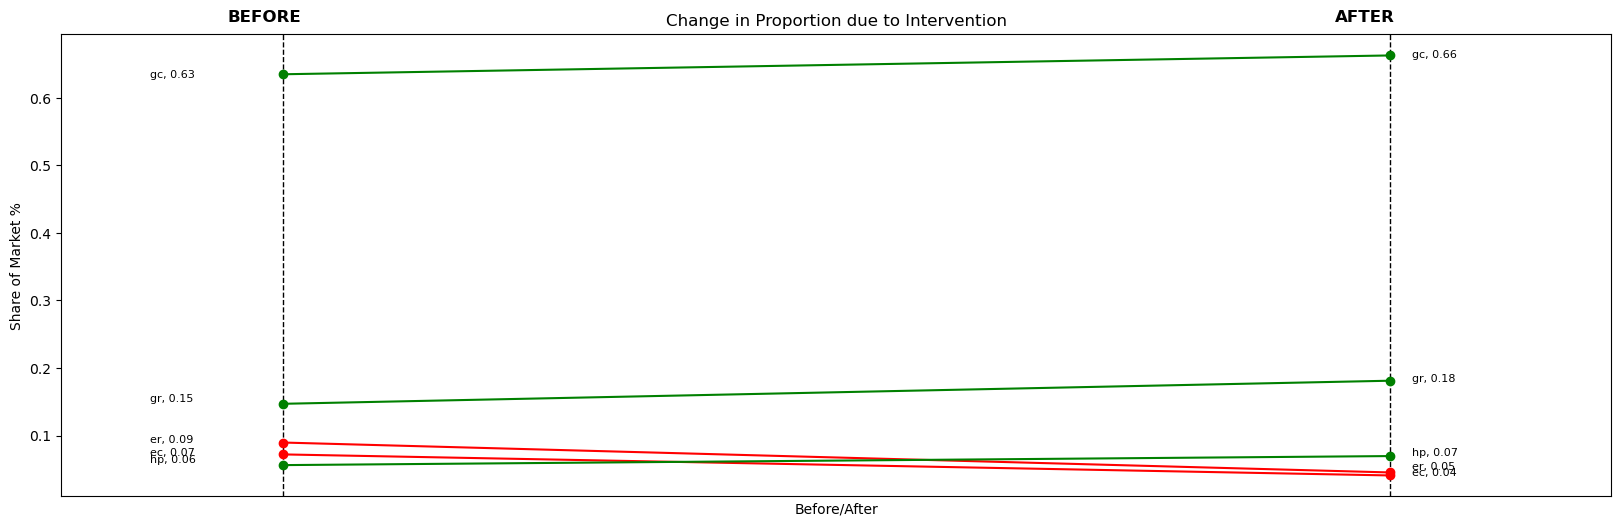

In [15]:
fig = nstL_1.make_change_plot(change_df=change_df_1, figsize=(20, 6))

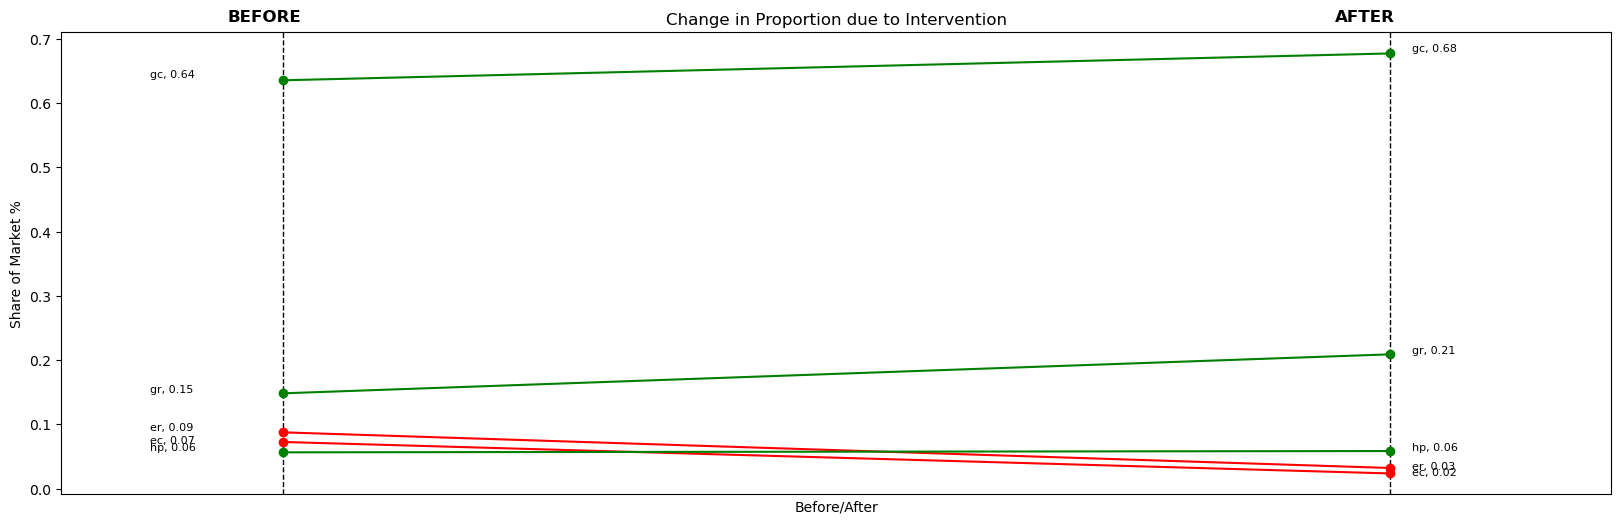

In [16]:
fig = nstL_2.make_change_plot(change_df=change_df_2, figsize=(20, 6))

### Choosing a Market Structure

Causal inference is hard and predicting the counterfactual actions of agents in a competitive market is very hard. There is no guarantee that a nested logit model will accurately represent the choice of any particular agent, but you can be hopeful that it highlights expected patterns of choice when the nesting structure reflects the natural segmentation of a market. Nests should group alternatives that share unobserved similarities, ideally driven by a transparent theory of the market structure. Well-specified nests should show stronger substitution within nests than across nests, and you can inspect the substitution patterns as above. Ideally you can always try and hold out some test data to evaluate the implications of your fitted model. Discrete choice models are causal inference models and their structural specification should support generalisable inference across future and counterfactual situations. 

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon Jun 16 2025

Python implementation: CPython
Python version       : 3.10.17
IPython version      : 8.35.0

pytensor: 2.31.3

arviz         : 0.21.0
pandas        : 2.2.3
pymc_marketing: 0.14.0
matplotlib    : 3.10.1
sys           : 3.10.17 | packaged by conda-forge | (main, Apr 10 2025, 22:23:34) [Clang 18.1.8 ]

Watermark: 2.5.0

